## 3. LightGBM_FeatureSearch

Abstract:
- Feature search
- do not shuffle train data

## Run name

In [1]:
import time

project_name = 'AtecAntiFraud'
step_name = 'LightGBM_FeatureSearch'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

## Important params

## Import PKGs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display
import seaborn as sns

import os
import sys
import gc
import math
import tqdm
import shutil
import zipfile
import pickle
import h5py
# import cv2
from PIL import Image

from tqdm import tqdm
import multiprocessing

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle

random_num = np.random.randint(10000)
cpu_amount = multiprocessing.cpu_count()

print('cpu_amount: %s' % (cpu_amount - 1))
print('random_num: %s' % random_num)

C:\Users\study\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


cpu_amount: 3
random_num: 955


In [257]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

import xgboost
from xgboost import plot_importance

## Project folders

In [258]:
cwd = os.getcwd()
feature_folder = os.path.join(cwd, 'feature')
figure_folder = os.path.join(cwd, 'figure')
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
log_folder = os.path.join(cwd, 'log')

test_a_csv_file = os.path.join(input_folder, 'atec_anti_fraud_test_a.csv')
test_b_csv_file = os.path.join(input_folder, 'atec_anti_fraud_test_b.csv')
train_csv_file = os.path.join(input_folder, 'atec_anti_fraud_train.csv')
sample_submission_csv_file = os.path.join(input_folder, 'demo.csv')

print(test_a_csv_file)
print(test_b_csv_file)
print(train_csv_file)
print(sample_submission_csv_file)

D:\bitbucket\atecantifraud\input\atec_anti_fraud_test_a.csv
D:\bitbucket\atecantifraud\input\atec_anti_fraud_test_b.csv
D:\bitbucket\atecantifraud\input\atec_anti_fraud_train.csv
D:\bitbucket\atecantifraud\input\demo.csv


## Load data

In [259]:
dtypes = {
    'f1': 'float64',
    'f2': 'float64',
    'f3': 'float64',
    'f4': 'float64',
    'f5': 'float64', #int64
    'f6': 'float64',
    'f7': 'float64',
    'f8': 'float64',
    'f9': 'float64',
    'f10': 'float64',
    'f11': 'float64',
    'f12': 'float64',
    'f13': 'float64',
    'f14': 'float64',
    'f15': 'float64',
    'f16': 'float64',
    'f17': 'float64',
    'f18': 'float64',
    'f19': 'float64',
    'f20': 'float64',
}
# dtypes = None

In [260]:
%%time
# rows = 10000
rows = None

train_csv = pd.read_csv(train_csv_file, nrows=rows, dtype=dtypes, parse_dates=['date'])
test_a_csv = pd.read_csv(test_a_csv_file, nrows=None, dtype=dtypes, parse_dates=['date'])
sample_submission_csv = pd.read_csv(sample_submission_csv_file)

print(train_csv.shape)
print(test_a_csv.shape)
print(sample_submission_csv.shape)

display(train_csv.head())
display(test_a_csv.head())
display(sample_submission_csv.head())

(994731, 300)
(491668, 299)
(3, 2)


,id,label,date,f1,f2,f3,f4,f5,f6,f7,...,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297
0,f10eb20f31cf7063ee8bdbd1272214e4d7e0193c8dbce4...,0,2017-11-03,0.0,0.0,0.0,0.0,100807.0,0.0,5.0,...,301.0,312.0,328.0,85.0,302.0,201.0,203.0,203.0,61.0,201.0
1,d861929b67938d06538b910b9f6b85f5eb62b6ad7361ba...,0,2017-09-17,0.0,1.0,1.0,1.0,100805.0,1.0,5.0,...,302.0,324.0,391.0,13.0,302.0,160.0,160.0,161.0,8.0,160.0
2,1270cb8a85eedd57672b2c6297fa5633e36773a2c3a351...,0,2017-10-22,0.0,0.0,1.0,0.0,100102.0,0.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9fa009724ee7ff9d688ae321304fbc78f608cdabbfdd2b...,0,2017-10-29,0.0,0.0,0.0,1.0,100807.0,1.0,4.0,...,302.0,322.0,341.0,57.0,251.0,175.0,176.0,176.0,49.0,150.0
4,1da482485d7e8bcefae7e9d0d1167cec3ac111cfa71d8b...,0,2017-10-02,1.0,1.0,0.0,1.0,100805.0,1.0,5.0,...,302.0,301.0,301.0,74.0,302.0,182.0,181.0,182.0,51.0,181.0


,id,date,f1,f2,f3,f4,f5,f6,f7,f8,...,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297
0,8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6f...,2018-01-20,0.0,0.0,1.0,1.0,100809.0,1.0,3.0,2.0,...,302.0,302.0,302.0,134.0,302.0,215.0,215.0,215.0,94.0,214.0
1,f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7...,2018-01-05,1.0,1.0,0.0,0.0,100808.0,1.0,5.0,2.0,...,39.0,40.0,40.0,39.0,40.0,39.0,39.0,39.0,39.0,39.0
2,ee85f808b1fd49eaba308527e1686c509dc8e3e5057488...,2018-01-09,0.0,0.0,0.0,0.0,100803.0,0.0,6.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
3,0df905aa187938d56a9b0816b13f54ac1f87d658a33cd0...,2018-01-18,1.0,1.0,1.0,1.0,100808.0,0.0,3.0,2.0,...,301.0,301.0,302.0,122.0,301.0,208.0,208.0,207.0,89.0,207.0
4,15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3e...,2018-01-09,1.0,1.0,1.0,1.0,100809.0,0.0,2.0,2.0,...,301.0,302.0,302.0,118.0,302.0,251.0,251.0,251.0,101.0,251.0


,id,score
0,e43b0d4dc42f55bf5def4b6155856d9494fb7626d43bba...,0.000648
1,c17d52961284a02589e5bb684caa38868191fdb64d4711...,0.000203
2,dcf26d76f6d77651fc1e85d0be5dd835f0871cb72a9b03...,0.001065


Wall time: 1min 2s


## Train data and test data unoin

In [261]:
true_train_csv = train_csv[train_csv['label'] == 0]
false_train_csv = train_csv[train_csv['label'] == 1]
black_train_csv = train_csv[train_csv['label'] == -1]
train_csv = train_csv[train_csv['label'] != -1]

print(true_train_csv.shape)
print(false_train_csv.shape)
print(true_train_csv.shape[0]/false_train_csv.shape[0])
print(black_train_csv.shape)
print(train_csv.shape)

(977884, 300)
(12122, 300)
80.67018643788154
(4725, 300)
(990006, 300)


In [262]:
id_data = train_csv['id']
id_test_a = test_a_csv['id']
train_csv = train_csv.drop(columns=['id'])
test_a_csv = test_a_csv.drop(columns=['id'])

y_data = train_csv['label']
train_csv = train_csv.drop(columns=['label'])

useless_features = []
x_data = train_csv.drop(columns=useless_features)
x_test_a = test_a_csv.drop(columns=useless_features)

print(train_csv.shape)
print(test_a_csv.shape)

print(id_data.shape)
print(id_test_a.shape)

print(y_data.shape)
print(x_data.shape)
print(x_test_a.shape)

(990006, 298)
(491668, 298)
(990006,)
(491668,)
(990006,)
(990006, 298)
(491668, 298)


In [263]:
len_x_data = len(x_data)
len_x_test_a = len(x_test_a)
print('len_x_data:\t', len_x_data)
print('len_x_test_a:\t', len_x_test_a)

data = pd.concat([x_data, x_test_a])

del train_csv
del test_a_csv
gc.collect()

len_x_data:	 990006
len_x_test_a:	 491668


7983

## Data type and describe

In [264]:
## preview columns
cols = data.columns
print('col\tdata_type\tmin\tmax\tdata\t')
for col in cols:
    print(col, end='\t')
    print(data[col].dtype, end='\t\t')
    print(min(data[col]), end='\t')
    print(max(data[col]), end='\t')
    print(list(data[col][:20]))
    for d in list(data[col][:20]):
        if data[col].dtype == 'float64' and d>0. and d != int(d):
            print('*'*80)
            break

col	data_type	min	max	data	
date	datetime64[ns]		2017-09-05 00:00:00	2018-02-05 00:00:00	[Timestamp('2017-11-03 00:00:00'), Timestamp('2017-09-17 00:00:00'), Timestamp('2017-10-22 00:00:00'), Timestamp('2017-10-29 00:00:00'), Timestamp('2017-10-02 00:00:00'), Timestamp('2017-10-12 00:00:00'), Timestamp('2017-09-27 00:00:00'), Timestamp('2017-10-27 00:00:00'), Timestamp('2017-09-26 00:00:00'), Timestamp('2017-10-11 00:00:00'), Timestamp('2017-11-04 00:00:00'), Timestamp('2017-10-30 00:00:00'), Timestamp('2017-09-16 00:00:00'), Timestamp('2017-10-30 00:00:00'), Timestamp('2017-11-04 00:00:00'), Timestamp('2017-09-14 00:00:00'), Timestamp('2017-10-01 00:00:00'), Timestamp('2017-10-05 00:00:00'), Timestamp('2017-11-01 00:00:00'), Timestamp('2017-10-27 00:00:00')]
f1	float64		0.0	2.0	[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0]
f2	float64		0.0	2.0	[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0

f60	float64		1.0	3.0	[1.0, 1.0, nan, 2.0, 2.0, 1.0, nan, 2.0, 1.0, 3.0, 2.0, 2.0, 1.0, 2.0, nan, 1.0, nan, 1.0, nan, nan]
f61	float64		1.0	9.0	[2.0, 4.0, nan, 3.0, 2.0, 2.0, nan, 2.0, 1.0, 5.0, 2.0, 1.0, 2.0, 2.0, nan, 4.0, nan, 2.0, nan, nan]
f62	float64		1.0	17.0	[2.0, 3.0, nan, 6.0, 1.0, 1.0, nan, 1.0, 1.0, 8.0, 2.0, 1.0, 1.0, 1.0, nan, 6.0, nan, 1.0, nan, nan]
f63	float64		1.0	32.0	[3.0, 3.0, nan, 6.0, 1.0, 2.0, nan, 2.0, 2.0, 17.0, 1.0, 2.0, 1.0, 1.0, nan, 6.0, nan, 1.0, nan, nan]
f64	float64		1.0	243.0	[96.0, 79.0, nan, nan, 89.0, 2.0, 201.0, nan, 1.0, 93.0, nan, 1.0, 2.0, nan, 1.0, 1.0, nan, 1.0, nan, nan]
f65	float64		1.0	59.0	[38.0, 12.0, nan, nan, 32.0, 2.0, 40.0, nan, 1.0, 36.0, nan, 2.0, 2.0, nan, 2.0, 1.0, nan, 1.0, nan, nan]
f66	float64		1.0	430.0	[301.0, 302.0, nan, nan, 301.0, 18.0, 302.0, nan, 18.0, 302.0, nan, 2.0, 17.0, nan, 26.0, 1.0, nan, 6.0, nan, nan]
f67	float64		1.0	302.0	[302.0, 32.0, nan, nan, 243.0, 16.0, 302.0, nan, 1.0, 301.0, nan, 1.0, 1.0, nan, 4.0, 1.0,

f118	float64		1.0	252.0	[192.0, 122.0, nan, nan, 218.0, 2.0, 227.0, nan, 1.0, 193.0, nan, 2.0, 1.0, nan, 2.0, 1.0, nan, 1.0, nan, nan]
f119	float64		1.0	252.0	[191.0, 121.0, nan, nan, 217.0, 2.0, 227.0, nan, 1.0, 192.0, nan, 2.0, 2.0, nan, 2.0, 2.0, nan, 2.0, nan, nan]
f120	float64		1.0	250.0	[190.0, 16.0, nan, nan, 177.0, 2.0, 224.0, nan, 2.0, 190.0, nan, 1.0, 1.0, nan, 2.0, 1.0, nan, 1.0, nan, nan]
f121	float64		1.0	250.0	[190.0, 121.0, nan, nan, 216.0, 2.0, 224.0, nan, 1.0, 191.0, nan, 2.0, 2.0, nan, 1.0, 2.0, nan, 1.0, nan, nan]
f122	float64		1.0	250.0	[190.0, 122.0, nan, nan, 216.0, 1.0, 225.0, nan, 2.0, 191.0, nan, 2.0, 2.0, nan, 2.0, 2.0, nan, 1.0, nan, nan]
f123	float64		1.0	37.0	[32.0, 32.0, nan, nan, 35.0, 2.0, 34.0, nan, 1.0, 33.0, nan, 1.0, 2.0, nan, 2.0, 2.0, nan, 2.0, nan, nan]
f124	float64		1.0	38.0	[33.0, 31.0, nan, nan, 34.0, 1.0, 35.0, nan, 1.0, 35.0, nan, 2.0, 2.0, nan, 2.0, 1.0, nan, 1.0, nan, nan]
f125	float64		1.0	34.0	[25.0, 13.0, nan, nan, 28.0, 1.0, 31.0, nan, 

f181	float64		1.0	11.0	[1.0, 1.0, 2.0, 3.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0]
f182	float64		1.0	11.0	[2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 4.0, 1.0, 1.0, 2.0, 2.0, 1.0, 3.0, 2.0, 2.0, 1.0, 3.0]
f183	float64		1.0	14.0	[4.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 2.0, 2.0, 4.0, 3.0, 1.0, 2.0, 2.0, 2.0, 5.0, 2.0, 2.0, 1.0, 2.0]
f184	float64		1.0	16.0	[3.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 3.0, 2.0, 3.0, 3.0, 2.0, 5.0, 3.0, 2.0, 2.0, 3.0]
f185	float64		1.0	22.0	[4.0, 2.0, 3.0, 2.0, 1.0, 2.0, 3.0, 1.0, 3.0, 4.0, 3.0, 2.0, 2.0, 5.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0]
f186	float64		1.0	4.0	[2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0]
f187	float64		1.0	6.0	[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0]
f188	float64		1.0	7.0	[1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0]
f189	float6

f245	float64		1.0	302.0	[5.0, 2.0, 2.0, 1.0, 2.0, 7.0, 8.0, 1.0, 1.0, 2.0, 94.0, 2.0, 2.0, 2.0, 3.0, 8.0, 154.0, 2.0, 2.0, 302.0]
f246	float64		1.0	302.0	[5.0, 1.0, 2.0, 1.0, 2.0, 8.0, 8.0, 2.0, 1.0, 1.0, 94.0, 1.0, 2.0, 1.0, 4.0, 28.0, 302.0, 3.0, 2.0, 302.0]
f247	float64		1.0	305.0	[10.0, 2.0, 7.0, 1.0, 3.0, 8.0, 8.0, 5.0, 1.0, 2.0, 94.0, 2.0, 9.0, 2.0, 4.0, 115.0, 301.0, 2.0, 1.0, 302.0]
f248	float64		1.0	463.0	[16.0, 2.0, 13.0, 2.0, 3.0, 7.0, 8.0, 7.0, 1.0, 1.0, 94.0, 2.0, 9.0, 2.0, 4.0, 143.0, 301.0, 2.0, 2.0, 301.0]
f249	float64		1.0	206.0	[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 5.0, 70.0, 2.0, 2.0, 82.0]
f250	float64		1.0	291.0	[2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 8.0, 127.0, 1.0, 2.0, 242.0]
f251	float64		1.0	291.0	[4.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 22.0, 235.0, 2.0, 1.0, 242.0]
f252	float64		1.0	291.0	[5.0, 1.0, 4.0, 1.0, 2.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 2

In [265]:
# train_max = train_csv.max()
# print(train_max.shape)
# display(train_max)

## Filter

## Feature engine

## Feature generate

In [266]:
## date
def do_date(df):
#     df['year'] = df['date'].dt.year.astype('uint16')
    df['month'] = df['date'].dt.month.astype('uint8')
    df['day'] = df['date'].dt.day.astype('uint8')
    df['weekday'] = df['date'].dt.weekday.astype('uint8')
    return df

data = do_date(data)
data = data.drop(columns=['date'])

pass

In [267]:
def do_plus(df, feature_couple, use_cols=None):
    new_feature_name = 'gd_' + '_d_'.join(feature_couple)
    if use_cols is not None and new_feature_name not in use_cols:
        print(new_feature_name, end=' ')
        return df
    df[new_feature_name] = df[feature_couple[0]] + df[feature_couple[1]]
#     display(df[new_feature_name].head())

# do_plus(data, ('f1', 'f2'))

In [268]:
def do_multiply(df, feature_couple, use_cols=None):
    new_feature_name = 'gm_' + '_m_'.join(feature_couple)
    if use_cols is not None and new_feature_name not in use_cols:
        print(new_feature_name, end=' ')
        return df
    df[new_feature_name] = (df[feature_couple[0]]+0.1) * (df[feature_couple[1]]+0.1)
#     display(df[new_feature_name].head())

# do_multiply(data, ('f1', 'f2'))

In [269]:
feature_couples = []
data_cols = list(data.columns)
print(data_cols)
# want to robust to remove id nad lable, so use try
try:
    data_cols.remove('id')
    data_cols.remove('label')
except Exception as ex:
    print(ex)
print(data_cols)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f1

In [270]:
%%time
len_data_cols = len(data_cols)
len_data_cols = 20
for i in range(len_data_cols - 1):
    for j in range(i+1, len_data_cols):
        if i == j:
            print('-', end='')
            continue
        if (data_cols[i], data_cols[j]) in feature_couples:
            print('+', end='')
            continue
        feature_couples.append((data_cols[i], data_cols[j]))
print(len(feature_couples))

190
Wall time: 2.96 ms


In [271]:
print(feature_couples[:20])

[('f1', 'f2'), ('f1', 'f3'), ('f1', 'f4'), ('f1', 'f5'), ('f1', 'f6'), ('f1', 'f7'), ('f1', 'f8'), ('f1', 'f9'), ('f1', 'f10'), ('f1', 'f11'), ('f1', 'f12'), ('f1', 'f13'), ('f1', 'f14'), ('f1', 'f15'), ('f1', 'f16'), ('f1', 'f17'), ('f1', 'f18'), ('f1', 'f19'), ('f1', 'f20'), ('f2', 'f3')]


In [272]:
use_cols = ['day', 'f237', 'f244', 'weekday', 'f246', 'f248', 'f215', 'f236', 'f234', 'f218', 'gm_f3_m_f19', 'f235', 'f245', 'f238', 'gm_f6_m_f7', 'f217', 'f216', 'f253', 'f247', 'gm_f6_m_f18', 'f252', 'gm_f7_m_f19', 'gm_f7_m_f14', 'gm_f14_m_f17', 'gm_f7_m_f15', 'gm_f11_m_f14', 'gm_f6_m_f19', 'gm_f6_m_f15', 'f82', 'gm_f7_m_f17']

for f_couple in feature_couples:
    print(f_couple)
    do_plus(data, f_couple, use_cols)
    do_multiply(data, f_couple, use_cols)

('f1', 'f2')
gd_f1_d_f2 gm_f1_m_f2 ('f1', 'f3')
gd_f1_d_f3 gm_f1_m_f3 ('f1', 'f4')
gd_f1_d_f4 gm_f1_m_f4 ('f1', 'f5')
gd_f1_d_f5 gm_f1_m_f5 ('f1', 'f6')
gd_f1_d_f6 gm_f1_m_f6 ('f1', 'f7')
gd_f1_d_f7 gm_f1_m_f7 ('f1', 'f8')
gd_f1_d_f8 gm_f1_m_f8 ('f1', 'f9')
gd_f1_d_f9 gm_f1_m_f9 ('f1', 'f10')
gd_f1_d_f10 gm_f1_m_f10 ('f1', 'f11')
gd_f1_d_f11 gm_f1_m_f11 ('f1', 'f12')
gd_f1_d_f12 gm_f1_m_f12 ('f1', 'f13')
gd_f1_d_f13 gm_f1_m_f13 ('f1', 'f14')
gd_f1_d_f14 gm_f1_m_f14 ('f1', 'f15')
gd_f1_d_f15 gm_f1_m_f15 ('f1', 'f16')
gd_f1_d_f16 gm_f1_m_f16 ('f1', 'f17')
gd_f1_d_f17 gm_f1_m_f17 ('f1', 'f18')
gd_f1_d_f18 gm_f1_m_f18 ('f1', 'f19')
gd_f1_d_f19 gm_f1_m_f19 ('f1', 'f20')
gd_f1_d_f20 gm_f1_m_f20 ('f2', 'f3')
gd_f2_d_f3 gm_f2_m_f3 ('f2', 'f4')
gd_f2_d_f4 gm_f2_m_f4 ('f2', 'f5')
gd_f2_d_f5 gm_f2_m_f5 ('f2', 'f6')
gd_f2_d_f6 gm_f2_m_f6 ('f2', 'f7')
gd_f2_d_f7 gm_f2_m_f7 ('f2', 'f8')
gd_f2_d_f8 gm_f2_m_f8 ('f2', 'f9')
gd_f2_d_f9 gm_f2_m_f9 ('f2', 'f10')
gd_f2_d_f10 gm_f2_m_f10 ('f2', 'f11')
gd_f2

In [273]:
%%time
use_cols = ['day', 'f237', 'f244', 'weekday', 'f246', 'f248', 'f215', 'f236', 'f234', 'f218', 'gm_f3_m_f19', 'f235', 'f245', 'f238', 'gm_f6_m_f7', 'f217', 'f216', 'f253', 'f247', 'gm_f6_m_f18', 'f252', 'gm_f7_m_f19', 'gm_f7_m_f14', 'gm_f14_m_f17', 'gm_f7_m_f15', 'gm_f11_m_f14', 'gm_f6_m_f19', 'gm_f6_m_f15', 'f82', 'gm_f7_m_f17']

cols = data.columns
for col in cols:
    if col not in use_cols:
        print(col, end=' ')
        data = data.drop(columns=[col])
        gc.collect()

f1 f2 f3 f4 f5 f6 f7 f8 f9 f10 f11 f12 f13 f14 f15 f16 f17 f18 f19 f20 f21 f22 f23 f24 f25 f26 f27 f28 f29 f30 f31 f32 f33 f34 f35 f36 f37 f38 f39 f40 f41 f42 f43 f44 f45 f46 f47 f48 f49 f50 f51 f52 f53 f54 f55 f56 f57 f58 f59 f60 f61 f62 f63 f64 f65 f66 f67 f68 f69 f70 f71 f72 f73 f74 f75 f76 f77 f78 f79 f80 f81 f83 f84 f85 f86 f87 f88 f89 f90 f91 f92 f93 f94 f95 f96 f97 f98 f99 f100 f101 f102 f103 f104 f105 f106 f107 f108 f109 f110 f111 f112 f113 f114 f115 f116 f117 f118 f119 f120 f121 f122 f123 f124 f125 f126 f127 f128 f129 f130 f131 f132 f133 f134 f135 f136 f137 f138 f139 f140 f141 f142 f143 f144 f145 f146 f147 f148 f149 f150 f151 f152 f153 f154 f155 f156 f157 f158 f159 f160 f161 f162 f163 f164 f165 f166 f167 f168 f169 f170 f171 f172 f173 f174 f175 f176 f177 f178 f179 f180 f181 f182 f183 f184 f185 f186 f187 f188 f189 f190 f191 f192 f193 f194 f195 f196 f197 f198 f199 f200 f201 f202 f203 f204 f205 f206 f207 f208 f209 f210 f211 f212 f213 f214 f219 f220 f221 f222 f223 f224 f225 f226 f2

In [274]:
print(data.shape)
print(data.columns)

(1481674, 30)
Index(['f82', 'f215', 'f216', 'f217', 'f218', 'f234', 'f235', 'f236', 'f237',
       'f238', 'f244', 'f245', 'f246', 'f247', 'f248', 'f252', 'f253', 'day',
       'weekday', 'gm_f3_m_f19', 'gm_f6_m_f7', 'gm_f6_m_f15', 'gm_f6_m_f18',
       'gm_f6_m_f19', 'gm_f7_m_f14', 'gm_f7_m_f15', 'gm_f7_m_f17',
       'gm_f7_m_f19', 'gm_f11_m_f14', 'gm_f14_m_f17'],
      dtype='object')


In [275]:
## preview columns again
cols = data.columns
print('col\tdata_type\tmax\tdata\t')
for col in cols[-10:]:
    print(col, end='\t')
    print(data[col].dtype, end='\t\t')
    print(max(data[col]), end='\t')
    print(list(data[col][:10]))

col	data_type	max	data	
gm_f6_m_f7	float64		29.109999999999996	[0.51, 5.61, 0.61, 4.51, 5.61, 0.61, 0.61, 0.61, 0.71, 0.21000000000000002]
gm_f6_m_f15	float64		8.61	[0.010000000000000002, 2.3100000000000005, 0.11000000000000001, 0.11000000000000001, 2.3100000000000005, 0.11000000000000001, 0.21000000000000002, 0.21000000000000002, 0.11000000000000001, 0.21000000000000002]
gm_f6_m_f18	float64		8.61	[0.21000000000000002, 2.3100000000000005, 0.11000000000000001, 1.2100000000000002, 2.3100000000000005, 0.11000000000000001, 0.21000000000000002, 0.21000000000000002, 0.21000000000000002, 0.21000000000000002]
gm_f6_m_f19	float64		8.61	[0.11000000000000001, 0.11000000000000001, 0.11000000000000001, 1.2100000000000002, 0.11000000000000001, 0.11000000000000001, 0.21000000000000002, 0.010000000000000002, 0.11000000000000001, 0.11000000000000001]
gm_f7_m_f14	float64		14.91	[10.709999999999999, 10.709999999999999, 12.81, 8.61, 5.61, 12.81, 6.71, 6.71, 7.8100000000000005, 4.41]
gm_f7_m_f15	float64		1

## Prepare x_data

In [276]:
x_data = data[:len_x_data]
x_test_a = data[len_x_data:]
print(x_data.shape)
print(x_test_a.shape)

print(list(x_data.columns))
print(list(x_data.dtypes))

(990006, 30)
(491668, 30)
['f82', 'f215', 'f216', 'f217', 'f218', 'f234', 'f235', 'f236', 'f237', 'f238', 'f244', 'f245', 'f246', 'f247', 'f248', 'f252', 'f253', 'day', 'weekday', 'gm_f3_m_f19', 'gm_f6_m_f7', 'gm_f6_m_f15', 'gm_f6_m_f18', 'gm_f6_m_f19', 'gm_f7_m_f14', 'gm_f7_m_f15', 'gm_f7_m_f17', 'gm_f7_m_f19', 'gm_f11_m_f14', 'gm_f14_m_f17']
[dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('uint8'), dtype('uint8'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]


## Split data

In [277]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=random_num, shuffle=False)

# x_train, y_train = shuffle(x_train, y_train, random_state=random_num)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(891005, 30)
(891005,)
(99001, 30)
(99001,)


## Train

In [278]:
%%time
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# lgb_train = lgb.Dataset(x_train, label=y_train)
# lgb_val = lgb.Dataset(x_val, label=y_val, reference=lgb_train)

colsample = 30.
colsample_bytree = round(colsample/len(x_train.columns), 4)
print('colsample_bytree: %.5f' % colsample_bytree)

# LightGBM parameters
param_grid = {
#     'task': 'train',
#     'num_boost_round': [200],
#     'early_stopping_rounds': [10],
#     'boosting_type': ['gbdt'], # (default="gbdt")
#     'num_leaves': [300], # (default=31)
#     'max_depth': [10, 8, 6], # (default=-1)
#     'learning_rate': [0.1], # (default=0.1)
#     'n_estimators': [2000, 500], # (default=10)
#     'max_bin': [1000, 255], # (default=255)
#     'subsample_for_bin': [100*10000], # (default=50000)
#     'objective': ['binary'], # (default=None)
#     'min_split_gain': [0.], # (default=0.)
#     'min_child_weight': [1e-3], # (default=1e-3)
#     'min_child_samples': [10], # (default=20)
#     'subsample': [0.7], # (default=1.)
#     'subsample_freq': [1], # (default=1)
#     'colsample_bytree': [0.9], # (default=1.)
#     'reg_alpha': [0., 0.3], # (default=0.)
#     'reg_lambda': [0., 0.3], # (default=0.)
#     'random_state': [random_num], # (default=None)
#     'n_jobs': [-1], # (default=-1)
#     'silent': [False], # (default=True)
#     'metric': ['auc', 'binary_logloss'],
}
# print('params: ', params)
# train
clf = lgb.LGBMClassifier(
#     'num_boost_round'=200,
#     'early_stopping_rounds'=10,
    boosting_type='gbdt', # (default="gbdt")
    num_leaves=512, # (default=31)
    max_depth=8, # (default=-1)
    learning_rate=0.1, # (default=0.1)
    n_estimators=500, # (default=10)
#     max_bin=255, # (default=255)
    subsample_for_bin=500, # (default=50000)
    objective='binary', # (default=None)
    class_weight=None,
    min_split_gain=0., # (default=0.)
    min_child_weight=1e-3, # (default=1e-3)
    min_child_samples=20, # (default=20)
    subsample=0.5, # (default=1.)
#     subsample_freq=1, # (default=1)
    colsample_bytree=colsample_bytree, # (default=1.)
    reg_alpha=0., # (default=0.)
    reg_lambda=0.3, # (default=0.)
    random_state=random_num, # (default=None)
    n_jobs=-1, # (default=-1)
    silent=False, # (default=True)
#     'metric'=['auc', 'binary_logloss'],
)
# gbm = lgb.train(
#     params,
#     train_set=lgb_train,
#     valid_sets=lgb_val
# )
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=1, scoring='roc_auc')
grid_search.fit(x_train, y_train)

colsample_bytree: 1.00000
Wall time: 5min 30s


In [279]:
%%time

print('*' * 80)
y_train_proba = grid_search.predict_proba(x_train)
print(y_train.shape)
print(y_train_proba.shape)
print(y_train_proba[:10])
y_train_pred = (y_train_proba[:, 1]>=0.5).astype(int)
acc_train = accuracy_score(y_train, y_train_pred)
roc_train = roc_auc_score(y_train, y_train_proba[:, 1])
print('acc_train: %.4f \t roc_train: %.4f' % (acc_train, roc_train))

# y_train_pred = grid_search.predict(x_train)
# acc_train = accuracy_score(y_train, y_train_pred)
# roc_train = roc_auc_score(y_train, y_train_proba[:, 1])
# print('acc_train: %.4f \t roc_train: %.4f' % (acc_train, roc_train))

y_val_proba = grid_search.predict_proba(x_val)
print(y_val.shape)
print(y_val_proba.shape)
print(y_val_proba[:10])
y_val_pred = (y_val_proba[:, 1]>=0.5).astype(int)
print(y_val.shape)
print(y_val_pred.shape)
acc_val = accuracy_score(y_val, y_val_pred)
roc_val = roc_auc_score(y_val, y_val_proba[:, 1])
print('acc_val:   %.4f \t roc_val:   %.4f' % (acc_val, roc_val))

********************************************************************************
(891005,)
(891005, 2)
[[9.99749851e-01 2.50149047e-04]
 [9.99993191e-01 6.80923537e-06]
 [9.99981229e-01 1.87709272e-05]
 [9.99701897e-01 2.98103093e-04]
 [9.99741802e-01 2.58198040e-04]
 [9.99973823e-01 2.61772561e-05]
 [9.99988044e-01 1.19564390e-05]
 [9.99880963e-01 1.19036679e-04]
 [9.99993140e-01 6.86040504e-06]
 [9.99731010e-01 2.68989544e-04]]
acc_train: 0.9971 	 roc_train: 0.9994
(99001,)
(99001, 2)
[[9.99821893e-01 1.78107032e-04]
 [9.99551017e-01 4.48983177e-04]
 [9.99928809e-01 7.11909256e-05]
 [9.96831617e-01 3.16838269e-03]
 [9.99426137e-01 5.73862780e-04]
 [9.86593456e-01 1.34065443e-02]
 [9.99999281e-01 7.18955973e-07]
 [9.99996951e-01 3.04922751e-06]
 [9.99934916e-01 6.50841078e-05]
 [9.99590630e-01 4.09370351e-04]]
(99001,)
(99001,)
acc_val:   0.9910 	 roc_val:   0.9663
Wall time: 53 s


In [280]:
print(grid_search.cv_results_)
print('*' * 60)
print(grid_search.grid_scores_ )
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.scorer_)
print('*' * 60)
print(type(grid_search.best_estimator_))
print(dir(grid_search.best_estimator_))

{'mean_fit_time': array([48.50049877]), 'std_fit_time': array([4.2381844]), 'mean_score_time': array([13.17732668]), 'std_score_time': array([0.3148234]), 'params': [{}], 'split0_test_score': array([0.95253986]), 'split1_test_score': array([0.95186495]), 'split2_test_score': array([0.95690295]), 'mean_test_score': array([0.95376925]), 'std_test_score': array([0.00223292]), 'rank_test_score': array([1]), 'split0_train_score': array([0.99989466]), 'split1_train_score': array([0.99989226]), 'split2_train_score': array([0.99987269]), 'mean_train_score': array([0.99988654]), 'std_train_score': array([9.83962243e-06])}
************************************************************
[mean: 0.95377, std: 0.00223, params: {}]
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=8, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
        n_jobs=-1, num_leaves=512, objective='binary', random_stat

In [281]:
cv_results = pd.DataFrame(grid_search.cv_results_)
display(cv_results)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,48.500499,13.177327,0.953769,0.999887,{},1,0.95254,0.999895,0.951865,0.999892,0.956903,0.999873,4.238184,0.314823,0.002233,0.00001


In [282]:
fe_times = grid_search.best_estimator_.booster_.feature_importance()
fe_name = grid_search.best_estimator_.booster_.feature_name()
print(fe_times)
print(fe_name)

[8480 2764 2039 2118 2625 2514 1898 1897 2028 2025 2587 2096 1796 2493
 3144 1994 2420 7743 3731 1955 3098 2113 2546 1787 3184 3346 3374 3061
 2205 1739]
['f82', 'f215', 'f216', 'f217', 'f218', 'f234', 'f235', 'f236', 'f237', 'f238', 'f244', 'f245', 'f246', 'f247', 'f248', 'f252', 'f253', 'day', 'weekday', 'gm_f3_m_f19', 'gm_f6_m_f7', 'gm_f6_m_f15', 'gm_f6_m_f18', 'gm_f6_m_f19', 'gm_f7_m_f14', 'gm_f7_m_f15', 'gm_f7_m_f17', 'gm_f7_m_f19', 'gm_f11_m_f14', 'gm_f14_m_f17']


,feature,importance
0,f82,8480
1,f215,2764
2,f216,2039
3,f217,2118
4,f218,2625


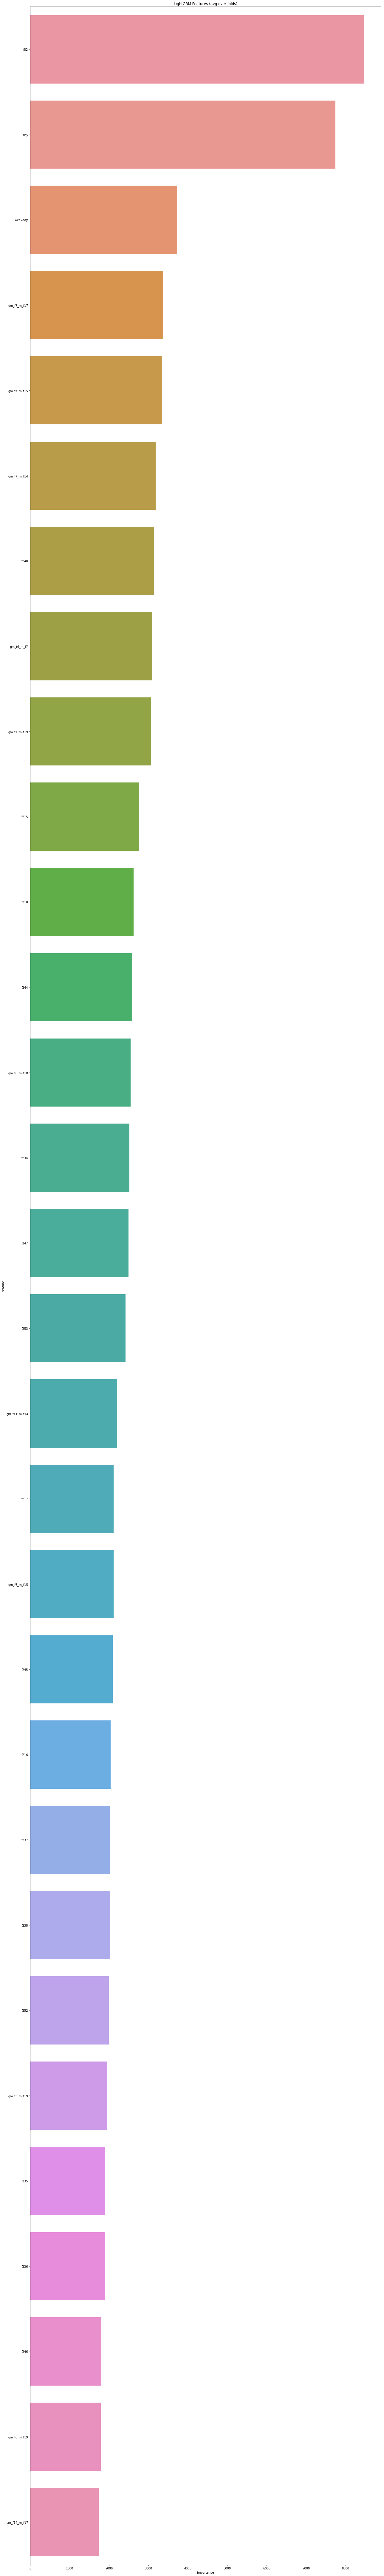

In [283]:
importance_score = pd.DataFrame(data={'feature': fe_name, 'importance': fe_times})
display(importance_score.head())

plt.figure(figsize=(18,120))
# sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
sns.barplot(x="importance", y="feature", data=importance_score.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [284]:
importance_score=importance_score.sort_values(by='importance', ascending=False)
importance_csv_file = os.path.join(log_folder, 'importance_%s.csv' % run_name)
print(importance_csv_file)
importance_score.to_csv(importance_csv_file, index = True)

display(importance_score['feature'][:5])
for i, item in enumerate(importance_score.values):
    print('%s\t%s\t%s' % (i, item[1], item[0]))

D:\bitbucket\atecantifraud\log\importance_AtecAntiFraud_LightGBM_FeatureSearch_20180609_211354.csv


0             f82
17            day
18        weekday
26    gm_f7_m_f17
25    gm_f7_m_f15
Name: feature, dtype: object

0	8480	f82
1	7743	day
2	3731	weekday
3	3374	gm_f7_m_f17
4	3346	gm_f7_m_f15
5	3184	gm_f7_m_f14
6	3144	f248
7	3098	gm_f6_m_f7
8	3061	gm_f7_m_f19
9	2764	f215
10	2625	f218
11	2587	f244
12	2546	gm_f6_m_f18
13	2514	f234
14	2493	f247
15	2420	f253
16	2205	gm_f11_m_f14
17	2118	f217
18	2113	gm_f6_m_f15
19	2096	f245
20	2039	f216
21	2028	f237
22	2025	f238
23	1994	f252
24	1955	gm_f3_m_f19
25	1898	f235
26	1897	f236
27	1796	f246
28	1787	gm_f6_m_f19
29	1739	gm_f14_m_f17


In [285]:
print('[', end='')
for i, f in enumerate(importance_score.values):
    print('\'%s\'' % f[0], end='')
    if i<50:
        print(', ', end='')
    else:
        print('', end='')
        break
print(']')

['f82', 'day', 'weekday', 'gm_f7_m_f17', 'gm_f7_m_f15', 'gm_f7_m_f14', 'f248', 'gm_f6_m_f7', 'gm_f7_m_f19', 'f215', 'f218', 'f244', 'gm_f6_m_f18', 'f234', 'f247', 'f253', 'gm_f11_m_f14', 'f217', 'gm_f6_m_f15', 'f245', 'f216', 'f237', 'f238', 'f252', 'gm_f3_m_f19', 'f235', 'f236', 'f246', 'gm_f6_m_f19', 'gm_f14_m_f17', ]


In [286]:
cols = ['day', 'f237', 'f244', 'weekday', 'f246', 'f248', 'f215', 'f236', 'f234', 'f218', 'gm_f3_m_f19', 'f235', 'f245', 'f238', 'gm_f6_m_f7', 'f217', 'f216', 'f253', 'f247', 'gm_f6_m_f18', 'f252', 'gm_f7_m_f19', 'gm_f7_m_f14', 'gm_f14_m_f17', 'gm_f7_m_f15', 'gm_f11_m_f14', 'gm_f6_m_f19', 'gm_f6_m_f15', 'f82', 'gm_f7_m_f17', 'gm_f7_m_f10', 'gm_f4_m_f7', 'gm_f7_m_f12', 'gm_f7_m_f13', 'gm_f14_m_f15', 'gd_f7_d_f19', 'f210', 'gm_f7_m_f16', 'gm_f7_m_f9', 'gm_f1_m_f7', 'gd_f7_d_f17', 'gd_f7_d_f18', 'gm_f6_m_f16', 'gm_f3_m_f7', 'gm_f1_m_f16', 'gd_f6_d_f7', 'f243', 'gd_f7_d_f14', 'gm_f18_m_f19', 'gd_f1_d_f7', 'f86']


## Predict

In [287]:
run_name_acc = run_name + '_' + str(int(roc_val*10000)).zfill(4)
print(run_name_acc)

AtecAntiFraud_LightGBM_FeatureSearch_20180609_211354_9663


In [288]:
y_test_a_proba = grid_search.predict_proba(x_test_a)

print(y_test_a_proba.shape)
print(y_test_a_proba[:10])

y_test_a_proba_true = y_test_a_proba[:, 1]

print(y_test_a_proba_true.shape)
print(y_test_a_proba_true[:10])

(491668, 2)
[[9.91450775e-01 8.54922503e-03]
 [9.95987876e-01 4.01212424e-03]
 [9.99998428e-01 1.57153084e-06]
 [9.98229812e-01 1.77018829e-03]
 [9.62750407e-01 3.72495932e-02]
 [9.92769244e-01 7.23075612e-03]
 [9.99850099e-01 1.49900763e-04]
 [9.99942191e-01 5.78094289e-05]
 [9.97430115e-01 2.56988474e-03]
 [9.98225567e-01 1.77443318e-03]]
(491668,)
[8.54922503e-03 4.01212424e-03 1.57153084e-06 1.77018829e-03
 3.72495932e-02 7.23075612e-03 1.49900763e-04 5.78094289e-05
 2.56988474e-03 1.77443318e-03]


In [289]:
y_data_proba = grid_search.predict_proba(x_data)

print(y_data_proba.shape)
print(y_data_proba[:10])

y_data_proba_true = y_data_proba[:, 1]

print(y_data_proba_true.shape)
print(y_data_proba_true[:10])

(990006, 2)
[[9.99749851e-01 2.50149047e-04]
 [9.99993191e-01 6.80923537e-06]
 [9.99981229e-01 1.87709272e-05]
 [9.99701897e-01 2.98103093e-04]
 [9.99741802e-01 2.58198040e-04]
 [9.99973823e-01 2.61772561e-05]
 [9.99988044e-01 1.19564390e-05]
 [9.99880963e-01 1.19036679e-04]
 [9.99993140e-01 6.86040504e-06]
 [9.99731010e-01 2.68989544e-04]]
(990006,)
[2.50149047e-04 6.80923537e-06 1.87709272e-05 2.98103093e-04
 2.58198040e-04 2.61772561e-05 1.19564390e-05 1.19036679e-04
 6.86040504e-06 2.68989544e-04]


In [290]:
def save_proba(y_data_proba, y_data, y_test_a_proba, id_test_a, file_name):
    id_test_a = [id_str.encode('utf-8') for id_str in id_test_a]
    print(id_test_a[:5])
    if os.path.exists(file_name):
        os.remove(file_name)
        print('File removed: %s' % file_name)
    with h5py.File(file_name) as h:
        h.create_dataset('y_data_proba', data=y_data_proba)
        h.create_dataset('y_data', data=y_data)
        h.create_dataset('y_test_a_proba', data=y_test_a_proba)
        h.create_dataset('id_test_a', data=id_test_a)
    print('File saved:   %s' % file_name)

def load_proba(file_name):
    with h5py.File(file_name, 'r') as h:
        y_data_proba = np.array(h['y_data_proba'])
        y_data = np.array(h['y_data'])
        y_test_a_proba = np.array(h['y_test_a_proba'])
        id_test_a = np.array(h['id_test_a'])
    print('File loaded:  %s' % file_name)
    id_test_a = [id_str.decode('utf-8') for id_str in id_test_a]
    print(id_test_a[:5])
    
    return y_data_proba, y_data, y_test_a_proba, id_test_a


y_proba_file = os.path.join(model_folder, 'proba_a_%s.p' % run_name_acc)
save_proba(
    y_data_proba, 
    y_data, 
    y_test_a_proba, 
    list(id_test_a),
    y_proba_file
)
y_data_proba, y_data, y_test_a_proba, id_test_a = load_proba(y_proba_file)

print('*'*80)
print(y_data_proba.shape)
print(y_data_proba[:10])
y_data_proba_true = y_data_proba[:, 1]
print(y_data_proba_true.shape)
print(y_data_proba_true[:10])

print('*'*80)
print(y_test_a_proba.shape)
print(y_test_a_proba[:10])
print(len(id_test_a))
y_test_a_proba_true = y_test_a_proba[:, 1]
print(y_test_a_proba_true.shape)
print(y_test_a_proba_true[:10])

[b'8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6fda5578f0e340908fa4', b'f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7c335237327bb02e02b', b'ee85f808b1fd49eaba308527e1686c509dc8e3e50574888e0f5f8bc21733711c', b'0df905aa187938d56a9b0816b13f54ac1f87d658a33cd06505b738c66b54fd3f', b'15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3ee00755b4949ef75c03']
File saved:   D:\bitbucket\atecantifraud\model\proba_a_AtecAntiFraud_LightGBM_FeatureSearch_20180609_211354_9663.p
File loaded:  D:\bitbucket\atecantifraud\model\proba_a_AtecAntiFraud_LightGBM_FeatureSearch_20180609_211354_9663.p
['8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6fda5578f0e340908fa4', 'f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7c335237327bb02e02b', 'ee85f808b1fd49eaba308527e1686c509dc8e3e50574888e0f5f8bc21733711c', '0df905aa187938d56a9b0816b13f54ac1f87d658a33cd06505b738c66b54fd3f', '15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3ee00755b4949ef75c03']
********************************************************************************
(9

In [291]:
# %%time
submission_csv_file = os.path.join(output_folder, 'pred_a_%s.csv' % run_name_acc)
print(submission_csv_file)
submission_csv = pd.DataFrame({ 'id': id_test_a , 'score': y_test_a_proba_true })
submission_csv.to_csv(submission_csv_file, index = False)
display(submission_csv.head())

D:\bitbucket\atecantifraud\output\pred_a_AtecAntiFraud_LightGBM_FeatureSearch_20180609_211354_9663.csv


,id,score
0,8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6f...,0.008549
1,f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7...,0.004012
2,ee85f808b1fd49eaba308527e1686c509dc8e3e5057488...,0.000002
3,0df905aa187938d56a9b0816b13f54ac1f87d658a33cd0...,0.001770
4,15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3e...,0.037250


In [292]:
print('Time cost: %.2f s' % (time.time() - t0))

print('random_num: ', random_num)
print(run_name_acc)
print('Done!')

Time cost: 4345.93 s
random_num:  955
AtecAntiFraud_LightGBM_FeatureSearch_20180609_211354_9663
Done!
